In [799]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates

In [800]:
sns.set()
%matplotlib inline

In [801]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [802]:
%autoreload 2

In [803]:
sns.set_context("talk")
sns.set_style("ticks")

In [804]:
df = pd.read_csv('COVID_19_CASES.csv', sep=',')
df.head()

,Date,Region,Cases,Recoveries,Deaths,Deaths per day,Cases per day,Recoveries per day
0,01/07/2020,Erongo,247,7,0,0,247,7
1,01/07/2020,Hardap,6,1,0,0,6,1
2,01/07/2020,Kharas,7,2,0,0,7,2
3,01/07/2020,Kavango East,0,0,0,0,0,0
4,01/07/2020,Kavango West,0,0,0,0,0,0


In [805]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df = df[df.region == 'Khomas'].reset_index()
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df.drop(columns=['index', 'region'])
df = df.sort_values(by='date')
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day
0,2020-07-01,25,14,0,0,25,14
1,2020-07-02,26,14,0,0,1,0
2,2020-07-03,27,14,0,0,1,0
3,2020-07-04,27,14,0,0,0,0
4,2020-07-05,28,14,0,0,1,0


In [806]:
assert (pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D') == df.date).all()

In [807]:
df.index = pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D')
df.index

DatetimeIndex(['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10',
               ...
               '2021-09-16', '2021-09-17', '2021-09-18', '2021-09-19',
               '2021-09-20', '2021-09-21', '2021-09-22', '2021-09-23',
               '2021-09-24', '2021-09-25'],
              dtype='datetime64[ns]', length=452, freq='D')

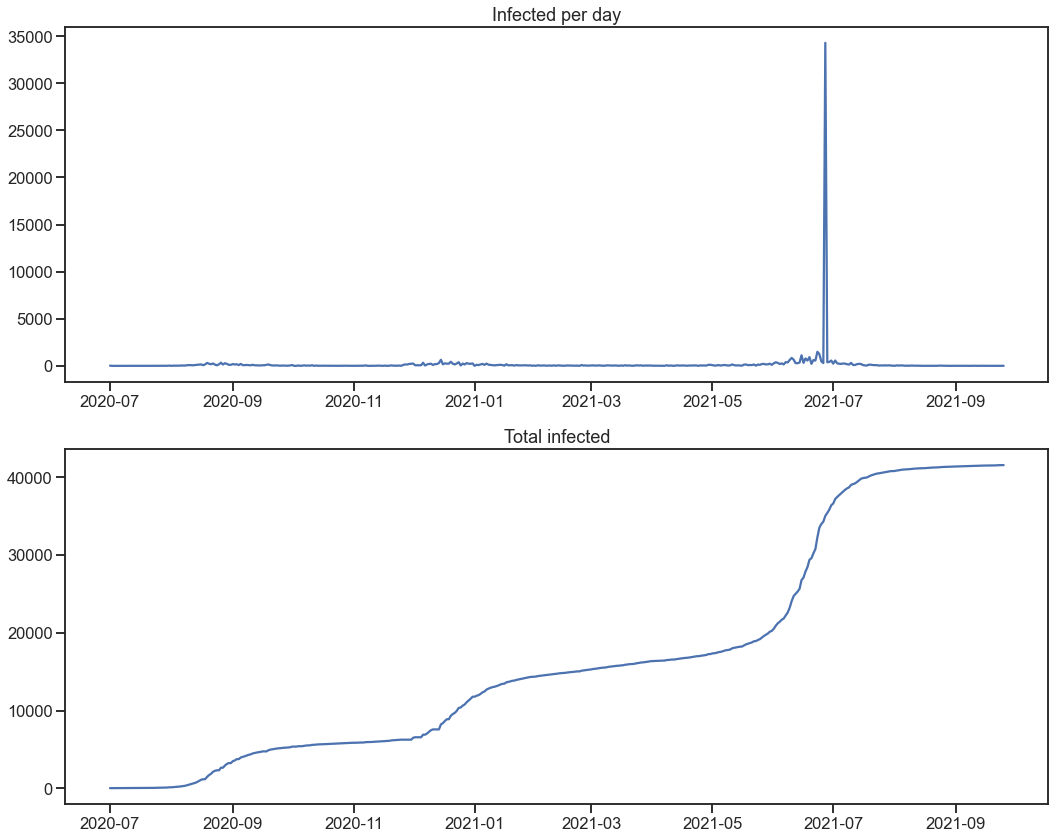

In [808]:
fig = plt.figure(figsize=(15,12))
ax1 = plt.subplot(2, 1, 2)
# df.total_infected.plot()
plt.plot(df.index, df.total_infected.values)
plt.title("Total infected")
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(df.index, df.infected_per_day.values)
plt.title("Infected per day")
plt.tight_layout()
plt.show()

In [809]:
df_smoothed = df.rolling(7).mean().round(5)
df_smoothed.columns = [col + '_ma7' for col in df_smoothed.columns]

full_df = pd.concat([df, df_smoothed], axis=1)

for column in full_df.columns:
    if column.endswith('_ma7'):
        original_column = column.strip('_ma7')
        full_df[column] = full_df[column].fillna(full_df[original_column])

In [810]:
df = full_df

In [811]:
from IPython.display import display, HTML

display(df)
# display(HTML(df.to_html()))

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7
2020-07-01,2020-07-01,25,14,0,0,25,14,25.00000,14.00000,0.00000,0.00000,25.00000,14.00000
2020-07-02,2020-07-02,26,14,0,0,1,0,26.00000,14.00000,0.00000,0.00000,1.00000,0.00000
2020-07-03,2020-07-03,27,14,0,0,1,0,27.00000,14.00000,0.00000,0.00000,1.00000,0.00000
2020-07-04,2020-07-04,27,14,0,0,0,0,27.00000,14.00000,0.00000,0.00000,0.00000,0.00000
2020-07-05,2020-07-05,28,14,0,0,1,0,28.00000,14.00000,0.00000,0.00000,1.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21,2021-09-21,41514,40289,856,0,0,0,41503.71429,40283.71429,854.71429,0.42857,4.42857,2.14286
2021-09-22,2021-09-22,41537,40294,856,0,23,5,41510.14286,40286.00000,855.00000,0.28571,6.42857,2.28571
2021-09-23,2021-09-23,41542,40296,858,2,5,2,41516.85714,40288.57143,855.57143,0.57143,6.71429,2.57143
2021-09-24,2021-09-24,41545,40296,858,0,3,0,41523.57143,40290.28571,856.14286,0.57143,6.71429,1.71429


In [812]:
NEW_STRAIN_DATE = '2021-06-15'

In [813]:
train_subset = df[
    (df.date <= NEW_STRAIN_DATE)]

In [814]:
import lmfit

In [815]:
class BarebonesSEIR:
    def __init__(self, params=None):
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=500_000, vary=False)
        params.add("epidemic_started_days_ago", value=30, vary=False)
        params.add("r0", value=4, min=3, max=5, vary=True)
        params.add("alpha", value=0.0064, min=0.005, max=0.0078, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D) = self.predict(t, (population - 1, 0, 1, 0, 0))
        
        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T

In [816]:
model = BarebonesSEIR()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D) = model.predict(train_t, train_initial_conditions)

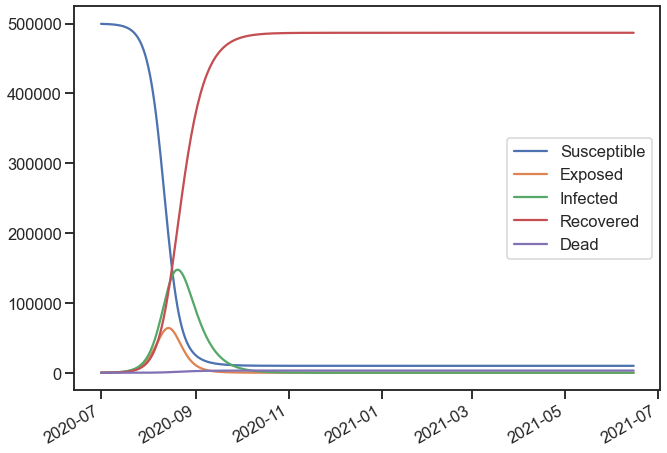

In [817]:
fig = plt.figure(figsize=(10,7))
plt.plot(train_subset.date, S, label='Susceptible')
plt.plot(train_subset.date, E, label='Exposed')
plt.plot(train_subset.date, I, label='Infected')
plt.plot(train_subset.date, R, label='Recovered')
plt.plot(train_subset.date, D, label='Dead')
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

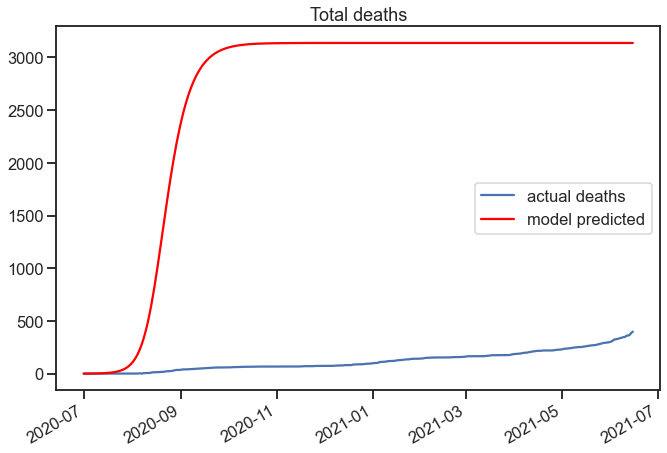

In [818]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='actual deaths')
plt.plot(train_subset.date, D, label='model predicted', color='red', linestyle='solid' )
plt.legend()
plt.title('Total deaths')
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

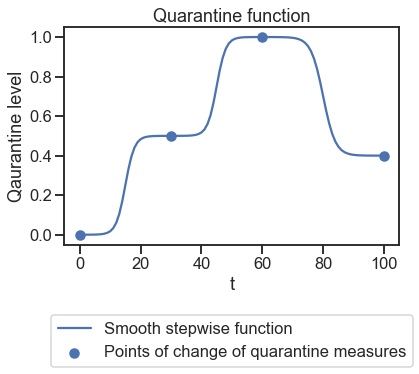

In [819]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(100)
coefficients = {
    0: 0,
    30: 0.5,
    60: 1,
    100: 0.4,
}

plt.title('Quarantine function')
plt.scatter(coefficients.keys(), coefficients.values(), label='Points of change of quarantine measures')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Smooth stepwise function')
plt.xlabel('t')
plt.ylabel('Qaurantine level')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

In [820]:
from sir.fitters import HiddenCurveFitter
from sir.models import SEIRHidden

In [821]:

stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, train_subset)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [822]:
result = fitter.result
result

In [823]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [824]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

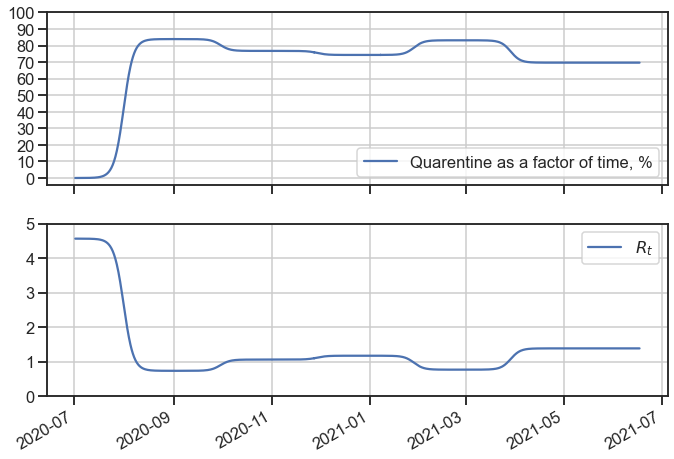

In [825]:
history_dates = df.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Quarentine as a factor of time, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

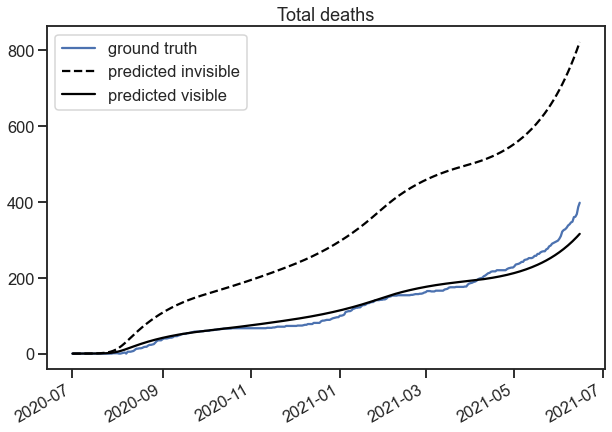

In [826]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
fig.autofmt_xdate()
plt.show()

In [827]:
from sir.utils import eval_on_select_dates_and_k_days_ahead, smape

In [828]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-10-01', end=last_day)[::20]
len(eval_dates)

17

In [829]:
def eval_hidden_khomas(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [830]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_khomas, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:   54.4s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:  1.4min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:  2.2min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:  2.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:  3.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:  5.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  6.6min finished


In [831]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]
x_dates

[Timestamp('2020-10-30 00:00:00'),
 Timestamp('2020-11-19 00:00:00'),
 Timestamp('2020-12-09 00:00:00'),
 Timestamp('2020-12-29 00:00:00'),
 Timestamp('2021-01-18 00:00:00'),
 Timestamp('2021-02-07 00:00:00'),
 Timestamp('2021-02-27 00:00:00'),
 Timestamp('2021-03-19 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-04-28 00:00:00'),
 Timestamp('2021-05-18 00:00:00'),
 Timestamp('2021-06-07 00:00:00'),
 Timestamp('2021-06-27 00:00:00'),
 Timestamp('2021-07-17 00:00:00'),
 Timestamp('2021-08-06 00:00:00'),
 Timestamp('2021-08-26 00:00:00'),
 Timestamp('2021-09-15 00:00:00')]

In [832]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

In [833]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]

In [834]:
overall_errors_model

[31.158861708685308,
 4.37221563681786,
 4.9200042725921715,
 4.892448730337067,
 16.696424619019933,
 85.84271935950898,
 57.7133636430991,
 20062.222281316594,
 10.224147142530178,
 16029.446233490451,
 30.555872957311475,
 15447.034662677153,
 2265.367788204989,
 12838.435645577234,
 13247.712727883005,
 13850.700613106439,
 162.64353916518138]

In [835]:
print('MAE baseline', np.mean(overall_errors_baseline).round(3))
print('MAE model', np.mean(overall_errors_model).round(3))
print('SMAPE model', np.mean(overall_smape_model).round(3))

MAE baseline 35.88
MAE model 5538.232
SMAPE model 0.429


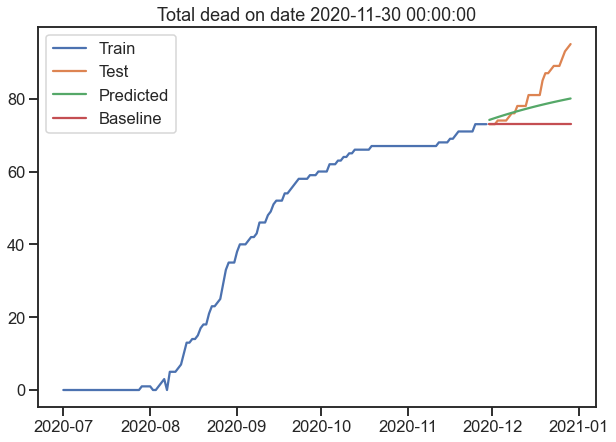

In [836]:
ix = np.random.choice(np.arange(len(train_dfs[-5:])))

train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [837]:
date_of_first_strain2_contact = '2021-08-10'

In [838]:
from sir.models import SEIRHiddenTwoStrains

In [839]:
future_dates = pd.date_range(start=date_of_first_strain2_contact, periods=365)
future_t = np.max(train_t) + 1 + np.arange(len(future_dates))

assert len(future_dates) == len(future_t)

In [840]:
def make_two_strain_forecast(model, beta2_mult=1.5, new_strain_ratio=0.01, **kwargs):
    strain2_model = SEIRHiddenTwoStrains.from_strain_one_model(model)
    strain2_model.params['beta2_mult'].value = beta2_mult
    
    for key, value in kwargs.items():
        strain2_model.params[key].value = value
    

    E2_0 = E[-1] * new_strain_ratio
    E1_0 = E[-1] *  (1-new_strain_ratio)
    Iv2_0 = Iv[-1] * new_strain_ratio
    Iv1_0 = Iv[-1] *  (1-new_strain_ratio)
    I2_0 = I[-1] * new_strain_ratio
    I1_0 = I[-1] *  (1-new_strain_ratio)

    future_initial_conds_two_strain = (S[-1],
                                       E1_0,
                                       I1_0,
                                       Iv1_0,
                                       E2_0,
                                       I2_0,
                                       Iv2_0,
                                       R[-1],
                                       Rv[-1],
                                       D[-1],
                                       Dv[-1])
    
    print('new strain I, Iv', I2_0, Iv2_0)
    
    future_states, future_history = strain2_model.predict(future_t,
                                                 future_initial_conds_two_strain)
    future_daylies = strain2_model.compute_daily_values(*future_states)
    return strain2_model, future_states, future_history, future_daylies

In [841]:
strain2_model, future_states, future_history, future_daylies = make_two_strain_forecast(model)

(future_S, future_E1, future_I1, future_Iv1, future_E2, future_I2, future_Iv2, future_R, future_Rv, future_D,
     future_Dv) = future_states

(future_new_exposed_s1,
    future_new_infected_inv_s1,
    future_new_infected_vis_s1,
    future_new_recovered_inv_s1,
    future_new_recovered_vis_s1,
    future_new_dead_inv_s1,
    future_new_dead_vis_s1,
    future_new_exposed_s2,
    future_new_infected_inv_s2,
    future_new_infected_vis_s2,
    future_new_recovered_inv_s2,
    future_new_recovered_vis_s2,
    future_new_dead_inv_s2,
    future_new_dead_vis_s2) = future_daylies

new strain I, Iv 150.75733743614282 26.625772276584254


In [842]:
future_daily_df = pd.DataFrame(
    {
        'date': future_dates[1:],
        't': future_t[1:],
        'new_exposed_s1': future_new_exposed_s1,
        'new_infected_inv_s1': future_new_infected_inv_s1,
        'new_infected_vis_s1': future_new_infected_vis_s1,
        'new_recovered_inv_s1': future_new_recovered_inv_s1,
        'new_recovered_vis_s1': future_new_recovered_vis_s1,
        'new_dead_inv_s1': future_new_dead_inv_s1,
        'new_dead_vis_s1': future_new_dead_vis_s1,
        'new_exposed_s2': future_new_exposed_s2,
        'new_infected_inv_s2': future_new_infected_inv_s2,
        'new_infected_vis_s2': future_new_infected_vis_s2,
        'new_recovered_inv_s2': future_new_recovered_inv_s2,
        'new_recovered_vis_s2': future_new_recovered_vis_s2,
        'new_dead_inv_s2': future_new_dead_inv_s2,
        'new_dead_vis_s2': future_new_dead_vis_s2
    },
    index=future_dates[1:])

In [843]:
Dates = (future_daily_df['date'] > '2021-09-30') & (future_daily_df['date'] <= '2021-10-31')
print(future_daily_df['new_infected_inv_s1'].loc[Dates])

2021-10-01     9475.652911
2021-10-02     9733.210055
2021-10-03     9996.151405
2021-10-04    10264.475395
2021-10-05    10538.170214
2021-10-06    10817.212932
2021-10-07    11101.568568
2021-10-08    11391.189104
2021-10-09    11686.012434
2021-10-10    11985.961297
2021-10-11    12290.942091
2021-10-12    12600.843653
2021-10-13    12915.536160
2021-10-14    13234.869494
2021-10-15    13558.672127
2021-10-16    13886.749640
2021-10-17    14218.883137
2021-10-18    14554.827837
2021-10-19    14894.311525
2021-10-20    15237.032815
2021-10-21    15582.659685
2021-10-22    15930.827700
2021-10-23    16281.138402
2021-10-24    16633.157718
2021-10-25    16986.414445
2021-10-26    17340.398370
2021-10-27    17694.559044
2021-10-28    18048.304394
2021-10-29    18400.998689
2021-10-30    18751.962735
2021-10-31    19100.471728
Freq: D, Name: new_infected_inv_s1, dtype: float64
